### **Importing Libraries**

In [1]:
import torch
import math
import copy
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
import numpy as np
from collections import defaultdict
import torch.optim as optim
import string
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cuda


### **Importing and Cleaning Dataset**

### **Loading Corpus**

In [2]:
def retrieve_corpus(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        corpus = []
        for line in file:
            # print(line.strip().lower())
            corpus.append(line.lower())
        return corpus

corpus_en = retrieve_corpus("./train.en")
corpus_fr = retrieve_corpus("./train.fr")
corpus_en_val = retrieve_corpus("./dev.en")
corpus_fr_val = retrieve_corpus("./dev.fr")
corpus_en_test = retrieve_corpus("./test.en")
corpus_fr_test = retrieve_corpus("./test.fr")


print("Dataset Loaded")

Dataset Loaded


### **Tokenization and Emmbedding**

#### **For English**

In [3]:
def remove_punctuation(tokenized_sentence):
    return [word for word in tokenized_sentence if word not in string.punctuation]

train_data_en = [remove_punctuation(word_tokenize(sentence)) for sentence in corpus_en]
val_data_en = [remove_punctuation(word_tokenize(sentence)) for sentence in corpus_en_val]

# Replacing words with frequency less than 5 with <unk>
word_freq={}
threshold = 3
for _, sentence in enumerate(train_data_en):
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

for _, sentence in enumerate(val_data_en):
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

vocab_en = ["<pad>", "<sos>", "<eos>", "<unk>"]
for i, sentence in enumerate(train_data_en):
    for j,word in enumerate(sentence):
        if word_freq[word] < threshold:
            train_data_en[i][j] = "<unk>"

for i, sentence in enumerate(val_data_en):
    for j,word in enumerate(sentence):
        if word_freq[word] < threshold:
            val_data_en[i][j] = "<unk>"

# Creating Vocabulary of English
for word in word_freq:
    if word_freq[word]>=threshold:
        vocab_en.append(word)

word2idx_en = {}
idx2word_en = {}
for i, word in enumerate(vocab_en):
    word2idx_en[word] = i
    idx2word_en[i] = word

#### **For French**

In [4]:
train_data_fr = [remove_punctuation(word_tokenize(sentence)) for sentence in corpus_fr]
val_data_fr = [remove_punctuation(word_tokenize(sentence)) for sentence in corpus_fr_val]


# Replacing words with frequency less than 5 with <unk>
word_freq={}
threshold = 3
for _, sentence in enumerate(train_data_fr):
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

for _, sentence in enumerate(val_data_fr):
    for word in sentence:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

vocab_fr = ["<pad>", "<sos>", "<eos>", "<unk>"]
for i, sentence in enumerate(train_data_fr):
    for j,word in enumerate(sentence):
        if word_freq[word] < threshold:
            train_data_fr[i][j] = "<unk>"

for i, sentence in enumerate(val_data_fr):
    for j,word in enumerate(sentence):
        if word_freq[word] < threshold:
            val_data_fr[i][j] = "<unk>"

# Creating Vocabulary of French
for word in word_freq:
    if word_freq[word]>=threshold:
        vocab_fr.append(word)

word2idx_fr = {}
idx2word_fr = {}
for i, word in enumerate(vocab_fr):
    word2idx_fr[word] = i
    idx2word_fr[i] = word
print(len(word2idx_en))
print(len(word2idx_fr))

10084
12787


### **Creating Training Data**

In [5]:
print(f"Training data size (English): {len(train_data_en)}")
print(f"Training data size (French): {len(train_data_fr)}")
print(f"Validating data size (English): {len(val_data_en)}")
print(f"Validating data size (French): {len(val_data_fr)}")

Training data size (English): 30000
Training data size (French): 30000
Validating data size (English): 887
Validating data size (French): 887


### **Creating Test Data**

In [6]:
test_data_en = [remove_punctuation(word_tokenize(sentence)) for sentence in corpus_en_test]
test_data_fr = [remove_punctuation(word_tokenize(sentence)) for sentence in corpus_fr_test]

print(f"Testing data size (English): {len(test_data_en)}")
print(f"Testing data size (French): {len(test_data_fr)}")

Testing data size (English): 1305
Testing data size (French): 1305


### **Positional Encoding**

In [7]:
class PosEncoding(nn.Module):
    def __init__(self, model_dim, max_len):
        super(PosEncoding, self).__init__()
        pos_code = torch.zeros(max_len, model_dim)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        scale = torch.exp(torch.arange(0, model_dim, 2, dtype=torch.float) *
                          -(math.log(10000.0) / model_dim))

        pos_code[:, 0::2] = torch.sin(pos * scale)
        pos_code[:, 1::2] = torch.cos(pos * scale)

        self.register_buffer('pos_code', pos_code.unsqueeze(0))

    def forward(self, inp):
        seq_len = inp.size(1)
        inp = inp + self.pos_code[:, :seq_len]

        return inp

### **Multi Head Attention**

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.dim_key = self.model_dim // self.num_heads
        self.dropout = nn.Dropout(dropout)

        # Linear layers for query, key, and value
        self.query = nn.Linear(model_dim, model_dim)
        self.key = nn.Linear(model_dim, model_dim)
        self.value = nn.Linear(model_dim, model_dim)
        self.out = nn.Linear(model_dim, model_dim)

    def attention_val(self, Q, K, V, mask=None):
        score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.dim_key)
        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        attn_weight = self.dropout(torch.softmax(score, dim=-1))

        new_val = torch.matmul(attn_weight, V)
        return new_val

    def split_layers(self, x):
        batch_size, seq_len, model_dim = x.size()
        return x.view(batch_size, seq_len, self.num_heads, self.dim_key).transpose(1, 2)

    def combine_layers(self, x):
        batch_size, _, seq_len, dim_key = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.model_dim)

    def forward(self, Q, K, V, mask=None):
        # Split into multiple heads
        Q = self.split_layers(self.query(Q))
        K = self.split_layers(self.key(K))
        V = self.split_layers(self.value(V))

        layer_out = self.attention_val(Q, K, V, mask)
        final_output = self.out(self.combine_layers(layer_out))

        return final_output


### **FeedForward**

In [9]:
class FeedForward(nn.Module):
    def __init__(self, model_dim, hid_dim, dropout=0.1):
        super(FeedForward, self).__init__()
        self.l1 = nn.Linear(model_dim, hid_dim)
        self.ac1 = nn.ReLU().to(device)
        self.l2 = nn.Linear(hid_dim, model_dim)
        self.dropout=nn.Dropout(dropout)

    def forward(self, inp):
        inp = self.l1(inp)
        inp = self.dropout(self.ac1(inp))
        inp = self.l2(inp)
        return inp

### **Encoder**

In [10]:
class Encoder(nn.Module):
    def __init__(self, model_dim, num_heads, hid_dim, dropout):
        super(Encoder, self).__init__()
        self.self_attn = MultiHeadAttention(model_dim, num_heads,dropout)
        self.norm = nn.LayerNorm(model_dim)
        self.ffn = FeedForward(model_dim, hid_dim,dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp, mask):

        att_score = self.self_attn(inp, inp, inp, mask)
        inp = self.norm(inp + self.dropout(att_score))
        ffn_out = self.ffn(inp).to(device)
        inp = self.norm(inp + self.dropout(ffn_out))

        return inp

### **Decoder**

In [11]:
class Decoder(nn.Module):
    def __init__(self, model_dim, num_heads, hid_dim, dropout):
        super(Decoder, self).__init__()
        self.self_attn = MultiHeadAttention(model_dim, num_heads,dropout)
        self.cr_attn = MultiHeadAttention(model_dim, num_heads,dropout)
        self.norm = nn.LayerNorm(model_dim)
        self.ffn = FeedForward(model_dim, hid_dim,dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp, enc_output, src_mask, target_mask):

        att_score = self.self_attn(inp, inp, inp, target_mask)
        if isinstance(att_score, tuple):
                att_score = att_score[0]
        inp = self.norm(inp + self.dropout(att_score))
        attn_score = self.cr_attn(inp, enc_output, enc_output, src_mask)
        inp = self.norm(inp + self.dropout(attn_score))
        ffn_out = self.ffn(inp)
        inp = self.norm(inp + self.dropout(ffn_out).to(device))

        return inp

### **Transformer**

In [12]:
class Transformer(nn.Module):
    def __init__(self, vocab_size_en, vocab_size_fr, model_dim, num_layer, num_heads, hid_dim, max_len, dropout=0.1, pretrained_embeddings_en=None, pretrained_embeddings_fr=None):
        super(Transformer, self).__init__()
        self.model_dim = model_dim
        if pretrained_embeddings_en is not None:
            self.embed_en = nn.Embedding.from_pretrained(torch.tensor(pretrained_embeddings_en, dtype=torch.float), freeze=True)
        else:
            self.embed_en = nn.Embedding(vocab_size_en, model_dim)
        # Embeddings for French
        if pretrained_embeddings_fr is not None:
            self.embed_fr = nn.Embedding.from_pretrained(torch.tensor(pretrained_embeddings_fr, dtype=torch.float), freeze=True)
        else:
            self.embed_fr = nn.Embedding(vocab_size_fr, model_dim)

        self.pos_enc = PosEncoding(model_dim, max_len)
        self.encoders = nn.ModuleList([Encoder(model_dim, num_heads, hid_dim, dropout) for _ in range(num_layer)])
        self.decoders = nn.ModuleList([Decoder(model_dim, num_heads, hid_dim, dropout) for _ in range(num_layer)])
        self.final_layer = nn.Linear(model_dim, vocab_size_fr)
        self.max_len = max_len

    def decode(self, src, sos_token, eos_token, max_len=40):
        batch_size = src.size(0)

        src_emb = self.pos_enc(self.embed_en(src))
        for encoder in self.encoders:
            src_emb = encoder(src_emb, None)

        tgt = torch.ones(batch_size, 1).long().to(device)


        for _ in range(max_len):

            src_mask, tgt_mask = self.generate_square_subsequent_mask(src, tgt)
            tgt_emb = self.pos_enc(self.embed_fr(tgt))
            for decoder in self.decoders:
                tgt_emb = decoder(tgt_emb, src_emb, src_mask, tgt_mask)

            output = self.final_layer(tgt_emb)
            next_word = output[:, -1:, :]
            next_word = torch.argmax(next_word, dim=-1)
            tgt = torch.cat((tgt, next_word), dim=1)
            # tgt = out_labels

        return tgt


    def forward(self, src, target):
        src = src
        src_mask, target_mask = self.generate_square_subsequent_mask(src, target)
        src_mask = src_mask
        target_mask = target_mask
        src_emb = self.pos_enc(self.embed_en(src))
        target_emb = self.pos_enc(self.embed_fr(target))

        for encoder in self.encoders:
            src_emb = encoder(src_emb, src_mask)

        for decoder in self.decoders:
            target_emb = decoder(target_emb, src_emb, src_mask, target_mask)

        return self.final_layer(target_emb)

    def generate_square_subsequent_mask(self,src, target):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (target != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt_mask.size(2)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask.to(device)
        return src_mask, tgt_mask


### **Creating Datasets**

In [13]:
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        src = self.src_data[idx]
        tgt_input = self.tgt_data[idx]

        return src, tgt_input


### **Creating Input**

In [14]:
def prepare_data(sentences, word2idx,max_len=100):
    for i, sentence in enumerate(sentences):

        if len(sentence) > max_len-2:
            sentences[i] = sentence[:max_len-2]
            sentences[i] = ["<sos>"] + sentences[i] + ["<eos>"]
        else:
            sentences[i] = ["<sos>"] + sentences[i] + ["<eos>"]

    all_indices = []
    for sentence in sentences:
        index = []
        for word in sentence:
            if word in word2idx:
                index.append(word2idx[word])
            else:
                index.append(word2idx["<unk>"])

        index = index + [word2idx["<pad>"]] * (max_len-len(index))
        index = torch.tensor(index)
        all_indices.append(index)

    return all_indices

# Now prepare the datasets
trainIdx_en = prepare_data(train_data_en, word2idx_en)
trainIdx_fr = prepare_data(train_data_fr, word2idx_fr)
valIdx_en = prepare_data(val_data_en, word2idx_en)
valIdx_fr = prepare_data(val_data_fr, word2idx_fr)
testIdx_en = prepare_data(test_data_en, word2idx_en)
testIdx_fr = prepare_data(test_data_fr, word2idx_fr)

# Example output
print("Created input for loading")



Created input for loading


### **Train Model**

In [17]:
print("Training Begins")

dataset_train = TranslationDataset(trainIdx_en, trainIdx_fr)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

dataset_val = TranslationDataset(valIdx_en, valIdx_fr)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=16, shuffle=True)

model = Transformer(vocab_size_en=len(word2idx_en), vocab_size_fr=len(word2idx_fr),
                        model_dim=128, num_heads=4, num_layer=2, hid_dim=256, max_len=100, dropout=0.1)
model.to(device)

num_epochs = 15
learning_rate = 0.001
criterion = nn.CrossEntropyLoss(ignore_index = word2idx_fr["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_index, batch in enumerate(dataloader_train):
        context_words, target_words = batch
        context_words = context_words.to(device)
        target_words = target_words.to(device)

        optimizer.zero_grad()

        outputs = model(context_words, target_words[:, :-1])

        outputs = outputs.contiguous().view(-1, outputs.size(-1))
        target_words_out = target_words[:, 1:].contiguous().view(-1)

        loss = criterion(outputs, target_words_out)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)


    # Validation loop
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader_val:
            context_words, target_words = batch
            context_words = context_words.to(device)
            target_words = target_words.to(device)

            outputs = model(context_words, target_words[:, :-1])

            outputs = outputs.contiguous().view(-1, outputs.size(-1))
            target_words_out = target_words[:, 1:].contiguous().view(-1)

            loss = criterion(outputs, target_words_out)

            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += target_words_out.size(0)
            correct += (predicted == target_words_out).sum().item()


    avg_val_loss = total_val_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy:.2f}%')

print("Training and Validation Complete.")
# torch.save(model, './model.pth')


Training Begins
Epoch [1/15], Train Loss: 5.1394, Val Loss: 4.7797, Val Accuracy: 4.76%
Epoch [2/15], Train Loss: 4.0664, Val Loss: 4.3984, Val Accuracy: 5.67%
Epoch [3/15], Train Loss: 3.5439, Val Loss: 4.2352, Val Accuracy: 6.20%
Epoch [4/15], Train Loss: 3.1743, Val Loss: 4.1641, Val Accuracy: 6.52%
Epoch [5/15], Train Loss: 2.8994, Val Loss: 4.1477, Val Accuracy: 6.69%
Epoch [6/15], Train Loss: 2.6894, Val Loss: 4.1632, Val Accuracy: 6.71%
Epoch [7/15], Train Loss: 2.5280, Val Loss: 4.1361, Val Accuracy: 6.95%
Epoch [8/15], Train Loss: 2.3920, Val Loss: 4.1521, Val Accuracy: 6.99%
Epoch [9/15], Train Loss: 2.2789, Val Loss: 4.1542, Val Accuracy: 7.01%
Epoch [10/15], Train Loss: 2.1868, Val Loss: 4.1926, Val Accuracy: 7.13%
Epoch [11/15], Train Loss: 2.1031, Val Loss: 4.2183, Val Accuracy: 7.17%
Epoch [12/15], Train Loss: 2.0285, Val Loss: 4.2679, Val Accuracy: 7.18%
Epoch [13/15], Train Loss: 1.9610, Val Loss: 4.2843, Val Accuracy: 7.22%
Epoch [14/15], Train Loss: 1.9005, Val Loss:

#### **Plotting Graph**

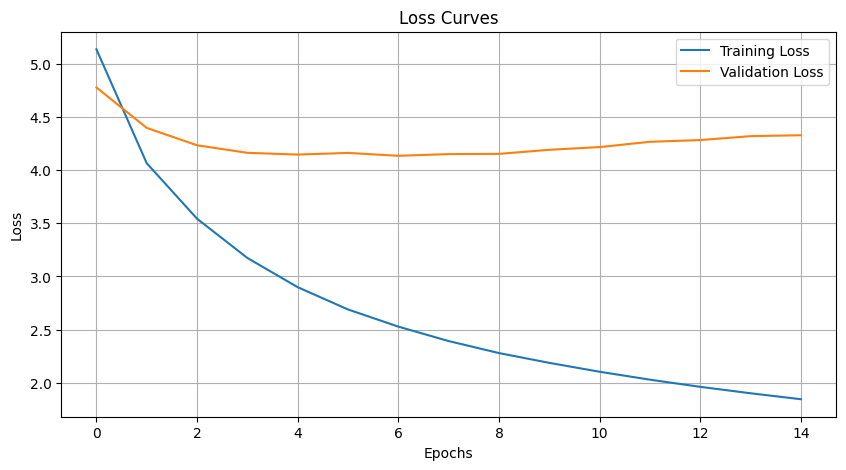

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig("./Comb-1.png")

### **Evaluate Model**

In [21]:
def smoothedBleu(reference, candidate):
    smoothing_function = SmoothingFunction().method7
    return sentence_bleu([reference], candidate, smoothing_function=smoothing_function)

print("Testing Begins")

dataset_test = TranslationDataset(testIdx_en, testIdx_fr)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=16)

model.eval()
correct = 0
total = 0
total_loss = 0
total_tokens = 0
criterion = nn.CrossEntropyLoss(ignore_index = word2idx_fr["<pad>"])
hypotheses = []
references = []
avg_bleu_score = 0


with open('testbleu.txt', 'w') as f:
    with torch.no_grad():
        for batch_index, batch in enumerate(dataloader_test):
            context_words, target_words= batch
            context_words = context_words.to(device)
            target_words = target_words.to(device)

            sos_token_id = word2idx_en["<sos>"]
            eos_token_id = word2idx_en["<eos>"]
            outputs = model(context_words, target_words[:, :-1])

            outputs = outputs.contiguous().view(-1, outputs.size(-1))
            target_words_out = target_words[:, 1:].contiguous().view(-1)

            loss = criterion(outputs, target_words_out)

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += target_words_out.size(0)
            correct += (predicted == target_words_out).sum().item()

            generated = model.decode(context_words, sos_token_id, eos_token_id, 100)
            for hyp, ref in zip(generated, target_words):
                hyp = hyp.tolist()
                ref = ref.tolist()

                hyp_words = [idx2word_fr[token] for token in hyp
                            if token not in {0, sos_token_id,eos_token_id}]
                # print(hyp_words)
                # print("Break")
                ref_words = [idx2word_fr[token] for token in ref
                            if token not in {0, sos_token_id,eos_token_id}]
                # print(ref_words)
                # print("Next")
            bleu_score = smoothedBleu(ref_words, hyp_words)
            f.write(f"{hyp_words} {bleu_score:.4f}\n")
            avg_bleu_score += bleu_score
                # print("Next")



        print(f'The avg Bleu Score is : {avg_bleu_score/len(dataloader_test)}')
        f.write(f"Averaged over all Sentences : {avg_bleu_score/len(dataloader_test):.4f}\n")

# for i in range(1, 5):
#     weights = [1/i] * i + [0] * (4-i)
#     bleu_score = corpus_bleu(references, hypotheses, weights=weights)
#     print(f"BLEU-{i} score: {bleu_score}")

accuracy = 100 * correct / total
average_loss = total_loss / len(dataloader_test)

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Average Test Loss: {average_loss:.4f}')

Testing Begins
The avg Bleu Score is : 0.18788674487605586
Test Accuracy: 7.98%
Average Test Loss: 3.5177


In [22]:
# Save the entire model
torch.save(model, './model.pth')